In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns

![alt text](./1.png "Title")

In [3]:
# Model 1
with pm.Model() as model1:
    capability = pm.Beta('capability', alpha=2, beta=2)
    success = pm.Bernoulli('success', p=capability)
    data1 = pd.DataFrame(pm.sample_prior_predictive(samples=500, model=model1))
    data1.head()

![alt text](./2.png "Title")

In [4]:
# Model 2
with pm.Model() as model2:
    capability = pm.Beta('capability', alpha=2, beta=2)
    
    interview = pm.Binomial('interview', n=20, p=capability)
    success = pm.Bernoulli('success', p=capability)
    data2 = pd.DataFrame(pm.sample_prior_predictive(samples=500, model=model2))
    data2.head()

![alt text](./3.png "Title")

In [4]:
# Model 3
with pm.Model() as model3:
    capability = pm.Beta('capability', alpha=2, beta=2)
    
    interview = pm.Binomial('interview', n=20, p=capability)
    gpa = pm.Deterministic('gpa', pm.Binomial('gpa_unscaled', n=16, p=capability) / 4.0)
    success = pm.Bernoulli('success', p=capability)
    
    data3 = pd.DataFrame(pm.sample_prior_predictive(samples=500, model=model3))
    data3.head()

![alt text](./4.png "Title")

In [13]:
def generate_samples(long_interview_question_count=100, interview_question_count=20, interview_correlation=0.4, capability_correlation=0.7, gpa_correlation=0.8, university_exam_correlation=0.77, highschool_exam_correlation=0.77, wealty_family_ratio=0.05, sample_count=1000):
    with pm.Model() as model:
        
        
        capability = pm.Beta('general_capability', alpha=2, beta=2)
        second_capability = pm.Beta('job_related_knowledge', alpha=2, beta=2)
        
        total_capability = pm.Deterministic('total_capability', capability*capability_correlation + second_capability*(1-capability_correlation))
        interview_capability = pm.Deterministic('interview_capability', capability*interview_correlation + second_capability*(1-interview_correlation))
        long_interview = pm.Binomial('long_interview', n=long_interview_question_count, p=interview_capability)
        interview = pm.Binomial('interview', n=interview_question_count, p=interview_capability)

        gpa_other_factors = pm.Beta('gpa_other_factors', alpha=2, beta=2)
        gpa = pm.Deterministic('gpa', pm.Binomial('gpa_unscaled', n=16, p=capability*gpa_correlation + gpa_other_factors*(1-gpa_correlation)) / 4.0)

        exam_other_factors = pm.Beta('exam_other_factors', alpha=2, beta=2)
        highschool_exam = pm.Binomial('highschool_exam', n=100, p=capability*(1-highschool_exam_correlation) + exam_other_factors*highschool_exam_correlation)
        university_exam = pm.Binomial('university_exam', n=100, p=capability*(1-university_exam_correlation) + exam_other_factors*university_exam_correlation)
        wealty_family = pm.Bernoulli('wealty_family', p=wealty_family_ratio)

        highschool =  pm.Bernoulli('highschool', p=pm.math.switch(highschool_exam >= 75, 1, 0)) 
        university =  pm.Bernoulli('university', p=pm.math.maximum(pm.math.switch(university_exam >= 75, 1, 0), wealty_family))
        #university = pm.math.switch(university_exam >= 90, 1, 0)
        
        return pd.DataFrame(pm.sample_prior_predictive(samples=1000, model=model))

data = generate_samples()
data.head()

,highschool,university,job_related_knowledge,interview,wealty_family,job_related_knowledge_logodds__,gpa_other_factors_logodds__,gpa_unscaled,general_capability,university_exam,exam_other_factors_logodds__,interview_capability,exam_other_factors,highschool_exam,gpa,total_capability,long_interview,general_capability_logodds__,gpa_other_factors
0,0,0,0.568154,15,0,0.274324,-0.362349,8,0.554712,21,-1.616885,0.562777,0.165635,25,2.00,0.558744,60,0.219726,0.410391
1,0,0,0.439764,10,0,-0.242118,-2.024449,10,0.644656,58,-0.038378,0.521721,0.490407,58,2.50,0.583189,44,0.595631,0.116660
2,0,0,0.468587,5,0,-0.125816,-0.002260,1,0.108379,29,-0.291773,0.324504,0.427570,39,0.25,0.216441,34,-2.107409,0.499435
3,0,0,0.499935,15,0,-0.000260,1.406163,9,0.470931,49,-0.179457,0.488333,0.455256,44,2.25,0.479632,48,-0.116408,0.803160
4,0,0,0.380384,7,0,-0.487917,-0.553765,8,0.418482,17,-1.790824,0.395623,0.142972,14,2.00,0.407053,41,-0.329008,0.364991


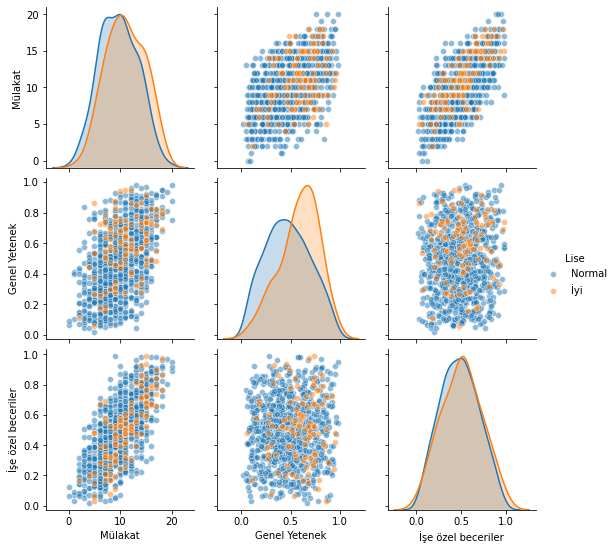

In [18]:
data = generate_samples(capability_correlation=0.6)
data = data.replace({'highschool': {0: 'Normal', 1: 'İyi'}}, inplace=False);
data[['Lise', 'Mülakat', 'Genel Yetenek', 'İşe özel beceriler']] = data[['highschool', 'interview', 'general_capability', 'job_related_knowledge']]
g = sns.pairplot(data[['Lise', 'Mülakat', 'Genel Yetenek', 'İşe özel beceriler']], hue="Lise", diag_kind="kde", diag_kws={'shade':True}, plot_kws={'alpha': 0.5});
g.savefig("output1.png")

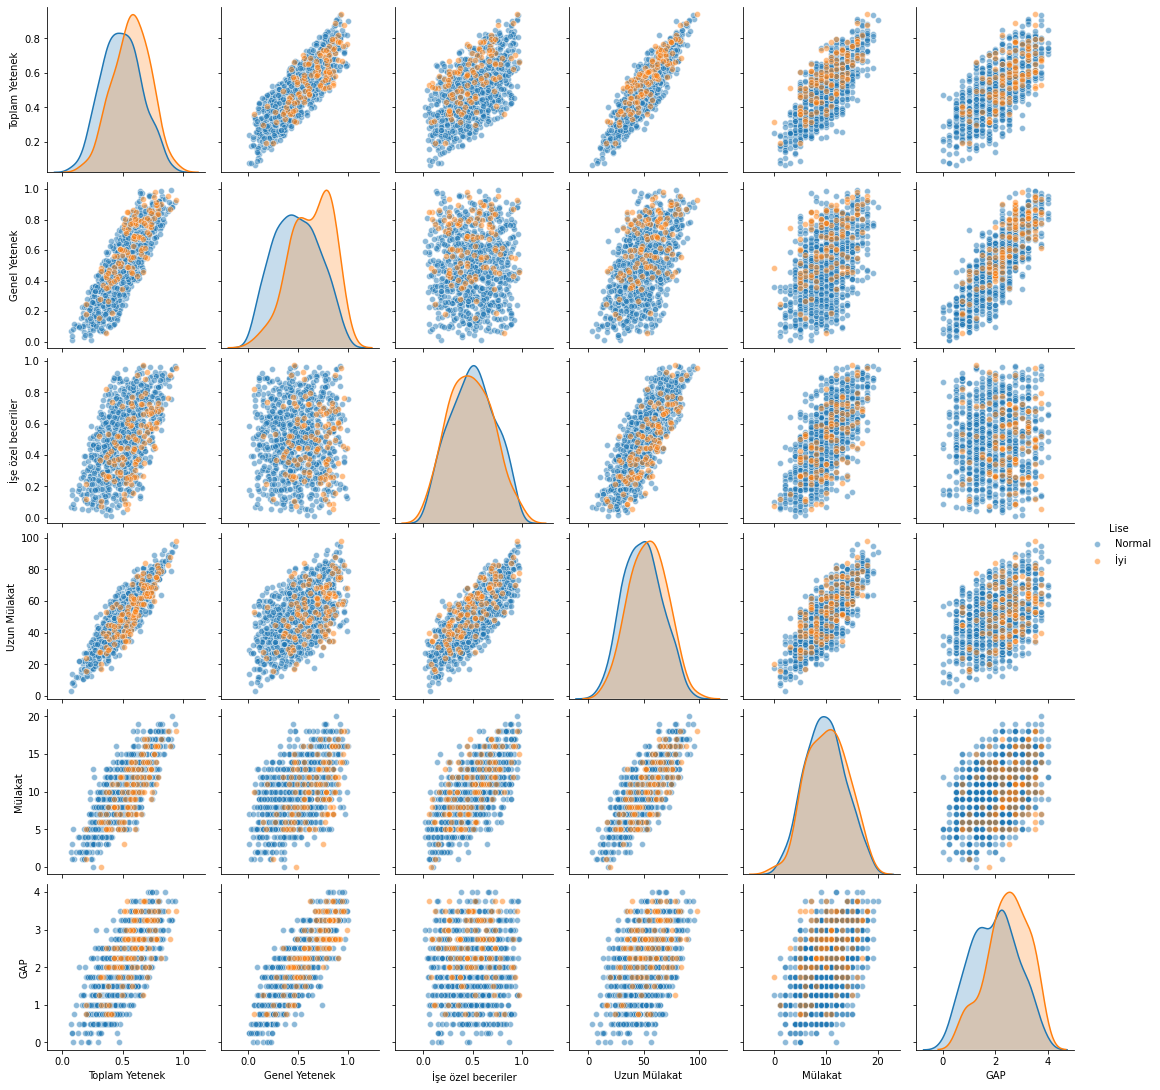

In [20]:
data = generate_samples(capability_correlation=0.6)
data = data.replace({'highschool': {0: 'Normal', 1: 'İyi'}}, inplace=False);
data[['Toplam Yetenek', 'Genel Yetenek', 'İşe özel beceriler', 'Uzun Mülakat', 'Mülakat', 'GAP', 'Lise']] = data[['total_capability', 'general_capability', 'job_related_knowledge', 'long_interview', 'interview', 'gpa', 'highschool']]
g = sns.pairplot(data[['Toplam Yetenek', 'Genel Yetenek', 'İşe özel beceriler', 'Uzun Mülakat', 'Mülakat', 'GAP', 'Lise']], hue="Lise", diag_kind="kde", diag_kws={'shade':True}, plot_kws={'alpha': 0.5});
g.savefig("output2.png")

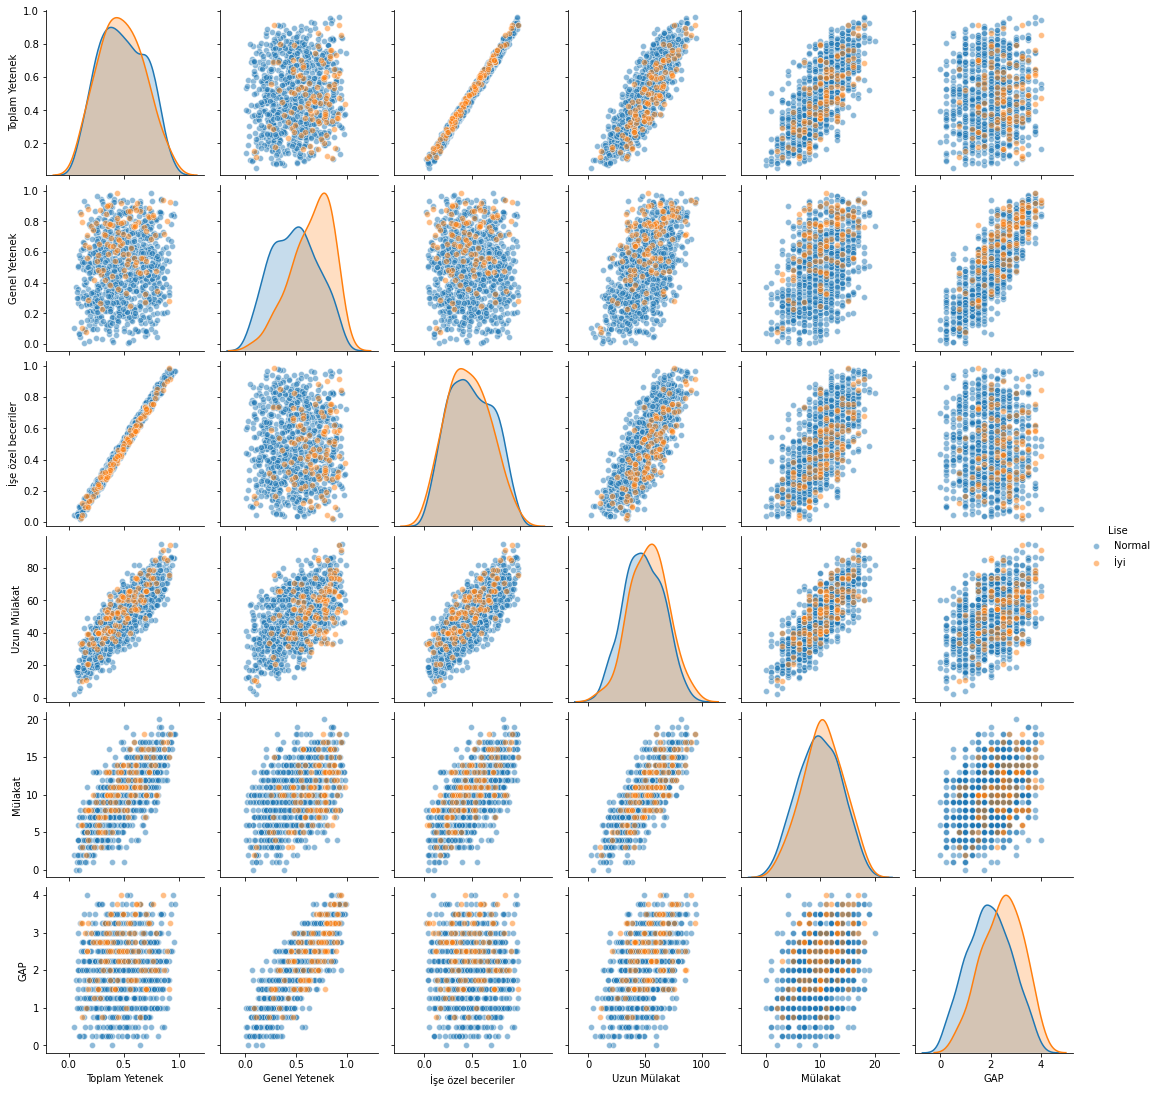

In [22]:
data = generate_samples(capability_correlation=0.1)
data = data.replace({'highschool': {0: 'Normal', 1: 'İyi'}}, inplace=False);
data[['Toplam Yetenek', 'Genel Yetenek', 'İşe özel beceriler', 'Uzun Mülakat', 'Mülakat', 'GAP', 'Lise']] = data[['total_capability', 'general_capability', 'job_related_knowledge', 'long_interview', 'interview', 'gpa', 'highschool']]
g = sns.pairplot(data[['Toplam Yetenek', 'Genel Yetenek', 'İşe özel beceriler', 'Uzun Mülakat', 'Mülakat', 'GAP', 'Lise']], hue="Lise", diag_kind="kde", diag_kws={'shade':True}, plot_kws={'alpha': 0.5});
g.savefig("output3.png")